# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


- Задача относится к NER, так как надо будет классифицировать токены последовательностей
- Это задача формулируется как задача последовательностной разметки. Каждому токену в последовательности сопоставляется метка из фиксированного набора классов
- Logistic Regression / SVM / Conditional Random Fields
- Есть метод Few-shot prompting с LLM для NER

| Метод | Предположение |
| ------ | ----- |
| Logistic Regression | Линейная разделимость классов|
|SVM|Максимизация зазора между классами|
|CRF|Зависимость между соседними метками|

- В случае NER используются метрики Recall + F1-score + Precision



### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


In [9]:
import pandas as pd
import glob

def load_annotated_file(filepath):
    rows = []

    with open(filepath, encoding="utf-8") as f:
        lines = f.readlines()

    document_id = lines[0].strip()

    for line in lines[1:]:
        line = line.strip()
        if not line:
            continue

        surface, lemma, entity_type, entity_id = line.split("\t")

        rows.append({
            "document_id": document_id,
            "document_text": surface,
            "entity": lemma,
            "gold_answer": entity_type
        })

    return rows


all_rows = []

files = glob.glob("./sample_pl_cs_ru_bg/annotated/ru/*")

for filepath in files:
    all_rows.extend(load_annotated_file(filepath))

df = pd.DataFrame(all_rows)
df.head()

print(df.columns)
print(df.head())
print(df.shape)
print("Total entities:", len(df))
print(df["gold_answer"].value_counts())

Index(['document_id', 'document_text', 'entity', 'gold_answer'], dtype='object')
  document_id  document_text         entity gold_answer
0       ru-10         Brexit         Brexit         EVT
1       ru-10       Альбиона        Альбион         LOC
2       ru-10       Альбионе        Альбион         LOC
3       ru-10  Борис Джонсон  Борис Джонсон         PER
4       ru-10       Британии       Британия         LOC
(153, 4)
Total entities: 153
gold_answer
PER    63
LOC    36
ORG    36
EVT    13
PRO     5
Name: count, dtype: int64


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5)
)

X = vectorizer.fit_transform(df["document_text"])

le = LabelEncoder()
y = le.fit_transform(df["gold_answer"])


### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


In [11]:
from sklearn.model_selection import train_test_split

doc_ids = df["document_id"].unique()
train_ids, test_ids = train_test_split(doc_ids, test_size=2, random_state=42)
train_df = df[df["document_id"].isin(train_ids)].reset_index(drop=True)
test_df = df[df["document_id"].isin(test_ids)].reset_index(drop=True)

print("Train documents:", len(train_ids), "Train entities:", len(train_df))
print("Test documents:", len(test_ids), "Test entities:", len(test_df))

Train documents: 7 Train entities: 130
Test documents: 2 Test entities: 23


In [12]:
def make_deepseek_input(row):
    text = row["document_text"]
    entity_type = row["gold_answer"]
    
    prompt = (
        f"Разметь сущность в тексте: '{text}'\n"
        f"Тип сущности: {entity_type}\n"
        f"Ответ в формате: {text} [{entity_type}]"
    )
    
    return prompt

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,4))
X_train = vectorizer.fit_transform(train_df['document_text'])
X_test = vectorizer.transform(test_df['document_text'])

le = LabelEncoder()
y_train = le.fit_transform(train_df['gold_answer'])
y_test = le.transform(test_df['gold_answer'])

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Number of classes:", len(le.classes_))


X_train shape: (130, 872)
X_test shape: (23, 872)
Number of classes: 5


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import joblib

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
joblib.dump(logreg, 'logreg_model.pkl')

nb = MultinomialNB()
nb.fit(X_train, y_train)
joblib.dump(nb, 'nb_model.pkl')

svc = LinearSVC(max_iter=1000, random_state=42)
svc.fit(X_train, y_train)
joblib.dump(svc, 'svc_model.pkl')


['svc_model.pkl']

### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


In [25]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

models = {'LogisticRegression': logreg, 'MultinomialNB': nb, 'LinearSVC': svc}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))



=== LogisticRegression ===
Accuracy: 0.7391304347826086
Classification report:
              precision    recall  f1-score   support

         EVT       1.00      1.00      1.00         2
         LOC       1.00      0.75      0.86         4
         ORG       0.29      0.67      0.40         3
         PER       0.91      0.77      0.83        13
         PRO       0.00      0.00      0.00         1

    accuracy                           0.74        23
   macro avg       0.64      0.64      0.62        23
weighted avg       0.81      0.74      0.76        23

Confusion matrix:
 [[ 2  0  0  0  0]
 [ 0  3  1  0  0]
 [ 0  0  2  1  0]
 [ 0  0  3 10  0]
 [ 0  0  1  0  0]]

=== MultinomialNB ===
Accuracy: 0.782608695652174
Classification report:
              precision    recall  f1-score   support

         EVT       1.00      1.00      1.00         2
         LOC       1.00      1.00      1.00         4
         ORG       0.40      0.67      0.50         3
         PER       0.83      0

In [27]:
import numpy as np

def score_fn(gold: pd.Series, pred: pd.Series) -> float:
    gold = np.array(gold)
    pred = np.array(pred)
    return np.mean(gold == pred)


for name, model in models.items():
    y_pred = model.predict(X_test)
    score = score_fn(y_test, y_pred)
    print(f"{name} custom score_fn:", score)

LogisticRegression custom score_fn: 0.7391304347826086
MultinomialNB custom score_fn: 0.782608695652174
LinearSVC custom score_fn: 0.7391304347826086


In [28]:
def test_score_fn():
    gold = pd.Series(['PER','LOC','ORG','EVT'])
    pred = pd.Series(['PER','ORG','ORG','EVT'])
    score = score_fn(gold, pred)
    expected = 0.75
    assert np.isclose(score, expected), f"Expected {expected}, got {score}"
    print("score_fn test passed")

test_score_fn()

score_fn test passed


### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

results = {}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_test_pred, labels=np.arange(len(le.classes_)), zero_division=0
    )
    
    results[name] = {
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }

entity_metrics = pd.DataFrame({
    'entity': le.classes_
})

for name, res in results.items():
    entity_metrics[f'{name}_precision'] = res['precision']
    entity_metrics[f'{name}_recall'] = res['recall']
    entity_metrics[f'{name}_f1'] = res['f1']

print(entity_metrics)


for name, res in results.items():
    test_df[f'{name}_pred'] = le.inverse_transform(res['y_test_pred'])

doc_metrics = test_df.groupby('document_id').apply(
    lambda x: pd.Series({
        'LogReg_acc': (x['gold_answer'] == x['LogisticRegression_pred']).mean(),
        'NB_acc': (x['gold_answer'] == x['MultinomialNB_pred']).mean(),
        'SVC_acc': (x['gold_answer'] == x['LinearSVC_pred']).mean()
    })
).reset_index()

print(doc_metrics)

  entity  LogisticRegression_precision  LogisticRegression_recall  \
0    EVT                      1.000000                   1.000000   
1    LOC                      1.000000                   0.750000   
2    ORG                      0.285714                   0.666667   
3    PER                      0.909091                   0.769231   
4    PRO                      0.000000                   0.000000   

   LogisticRegression_f1  MultinomialNB_precision  MultinomialNB_recall  \
0               1.000000                 1.000000              1.000000   
1               0.857143                 1.000000              1.000000   
2               0.400000                 0.400000              0.666667   
3               0.833333                 0.833333              0.769231   
4               0.000000                 0.000000              0.000000   

   MultinomialNB_f1  LinearSVC_precision  LinearSVC_recall  LinearSVC_f1  
0               1.0             1.000000          1.000000 

/var/folders/ss/1wdm068n7j58pxnbff3ktvqm0000gn/T/ipykernel_72810/2414600044.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  doc_metrics = test_df.groupby('document_id').apply(


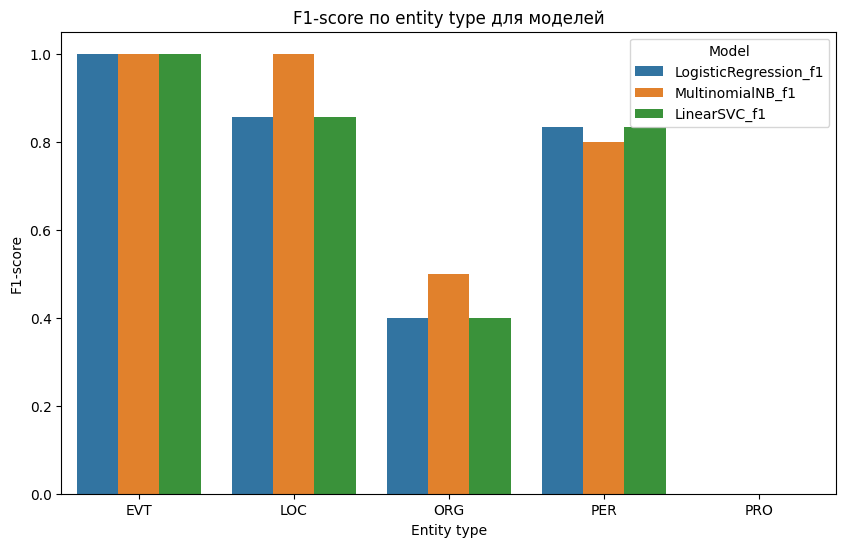

In [30]:
entity_metrics_melted = entity_metrics.melt(id_vars='entity', 
                                            value_vars=[col for col in entity_metrics.columns if 'f1' in col],
                                            var_name='model', value_name='f1_score')

plt.figure(figsize=(10,6))
sns.barplot(data=entity_metrics_melted, x='entity', y='f1_score', hue='model')
plt.title("F1-score по entity type для моделей")
plt.ylabel("F1-score")
plt.xlabel("Entity type")
plt.legend(title="Model")
plt.show()

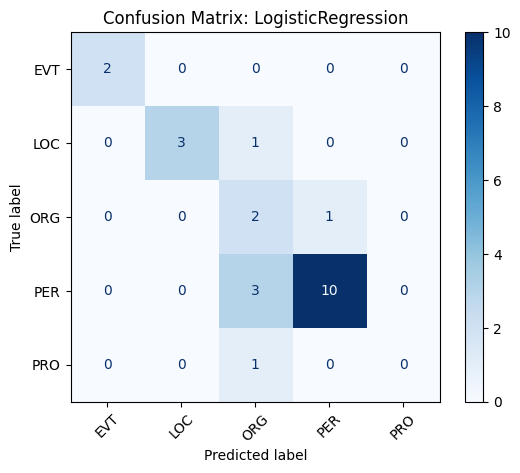

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model_name = 'LogisticRegression'
ConfusionMatrixDisplay.from_predictions(
    y_test, results[best_model_name]['y_test_pred'], display_labels=le.classes_, cmap='Blues', xticks_rotation=45
)
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()

In [32]:
for name, res in results.items():
    train_acc = (y_train == res['y_train_pred']).mean()
    test_acc = (y_test == res['y_test_pred']).mean()
    print(f"{name} - Train accuracy: {train_acc:.2f}, Test accuracy: {test_acc:.2f}")


LogisticRegression - Train accuracy: 0.98, Test accuracy: 0.74
MultinomialNB - Train accuracy: 0.95, Test accuracy: 0.78
LinearSVC - Train accuracy: 1.00, Test accuracy: 0.74


Модели переобучены, так как у меня Train accuracy >> Test accuracy. Но это логично, такак датасет очень мальнький. Можно попробовать применить регуляризацию.

In [37]:
def map_deepseek_to_tokens(df_test, ds_results):
    y_pred_ds = []

    for doc_id in df_test['document_id'].unique():
        doc_df = df_test[df_test['document_id'] == doc_id]
        doc_entities = ds_results.get(doc_id, [])

        for token in doc_df['document_text']:
            label = 'O'

            for entity_text, entity_type in doc_entities:
                if token in entity_text or entity_text in token:
                     if len(token) > 1:
                        label = entity_type
                        break
            y_pred_ds.append(label)

    return y_pred_ds

In [44]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report

deepseek_manual_results = {
    'brexit_ru.txt_file_1000': [
        ('Борис Джонсон', 'PER'), ('Дэвид Дэвис', 'PER'), ('Стив Бейкер', 'PER'),
        ('Тереза Мэй', 'PER'), ('Великобритания', 'LOC'), ('Соединенного Королевства', 'LOC'),
        ('ЕС', 'ORG'), ('The Guardian', 'ORG'), ('УНН', 'ORG'),
        ('британский парламент', 'ORG'), ('МИД', 'ORG'), ('Brexit', 'EVT')
    ],
    'brexit_ru.txt_file_1011': [
        ('Борис Джонсон', 'PER'), ('Тереза Мэй', 'PER'), ('Великобритания', 'LOC'),
        ('ЕС', 'ORG'), ('The Guardian', 'ORG'), ('Дэвид Дэвис', 'PER'),
        ('Палата общин', 'ORG'), ('Евросоюз', 'ORG'), ('Brexit', 'EVT'),
        ('29 марта', 'EVT')
    ],
    'brexit_ru.txt_file_1004': [
        ('Борис Джонсон', 'PER'), ('ТАСС', 'ORG'), ('Тереза Мэй', 'PER'),
        ('Дэвид Дэвис', 'PER'), ('Великобритания', 'LOC'), ('МИД Великобритании', 'ORG'),
        ('Евросоюз', 'ORG'), ('ЕС', 'ORG'), ('Германия', 'LOC'),
        ('Польша', 'LOC'), ('Лондон', 'LOC'), ('Западные Балканы', 'LOC'),
        ('Консервативная партия', 'ORG'), ('Brexit', 'EVT')
    ]
}

ds_rows = []

for doc_id, entities in deepseek_manual_results.items():
    for entity_text, entity_type in entities:
        ds_rows.append({
            'document_id': doc_id,
            'entity': entity_text,
            'deepseek_pred': entity_type
        })

ds_df = pd.DataFrame(ds_rows)
ds_df.head()

merged_df = test_df.merge(ds_df, left_on=['document_id','document_text'], 
                          right_on=['document_id','entity'], how='left')

merged_df['deepseek_pred'] = merged_df['deepseek_pred'].fillna('PRO')

target_labels = le.classes_
y_test_ds = y_test

ds_le = LabelEncoder()
ds_le.fit(target_labels)
deepseek_preds_tokens = ds_le.transform(merged_df['deepseek_pred'])

ds_f1 = f1_score(y_test_ds, deepseek_preds_tokens, labels=np.arange(len(target_labels)), 
                 average='weighted', zero_division=0)

print("DeepSeek weighted F1:", ds_f1)
print(classification_report(y_test_ds, deepseek_preds_tokens, target_names=target_labels, zero_division=0))




DeepSeek weighted F1: 0.003623188405797101
              precision    recall  f1-score   support

         EVT       0.00      0.00      0.00         2
         LOC       0.00      0.00      0.00         4
         ORG       0.00      0.00      0.00         3
         PER       0.00      0.00      0.00        13
         PRO       0.04      1.00      0.08         1

    accuracy                           0.04        23
   macro avg       0.01      0.20      0.02        23
weighted avg       0.00      0.04      0.00        23



## Сравние остальными моделями

In [45]:
comparison = pd.DataFrame({
    'Model': ['LogReg', 'MultinomialNB', 'LinearSVC', 'DeepSeek'],
    'F1_weighted': [
        f1_score(y_test, results['LogisticRegression']['y_test_pred'], average='weighted', zero_division=0),
        f1_score(y_test, results['MultinomialNB']['y_test_pred'], average='weighted', zero_division=0),
        f1_score(y_test, results['LinearSVC']['y_test_pred'], average='weighted', zero_division=0),
        ds_f1
    ]
})
print(comparison)


           Model  F1_weighted
0         LogReg     0.759213
1  MultinomialNB     0.778261
2      LinearSVC     0.759213
3       DeepSeek     0.003623


DeepSeek показал крайне плохие результаты.

### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


In [46]:
test_df['text_length'] = test_df['document_text'].apply(lambda x: len(x.split()))
train_df['text_length'] = train_df['document_text'].apply(lambda x: len(x.split()))

/var/folders/ss/1wdm068n7j58pxnbff3ktvqm0000gn/T/ipykernel_72810/3112680827.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('document_id').apply(


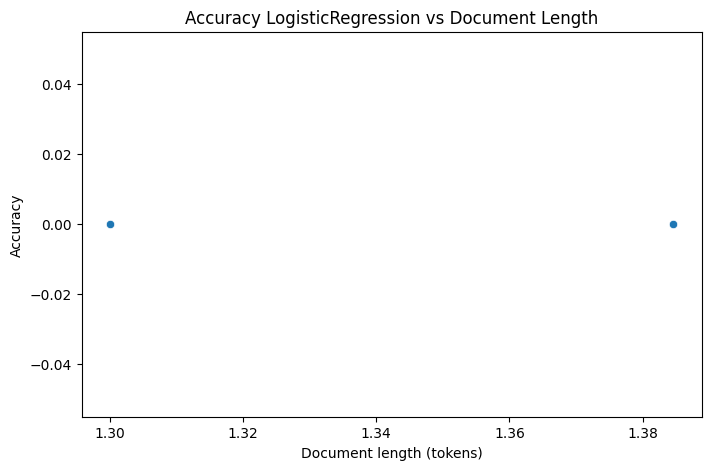

In [47]:
def accuracy_by_length(df, pred_col):
    return df.groupby('document_id').apply(
        lambda x: pd.Series({
            'accuracy': (x['gold_answer'] == x[pred_col]).mean(),
            'doc_length': x['text_length'].mean()
        })
    ).reset_index()

logreg_acc_len = accuracy_by_length(test_df.assign(LogisticRegression_pred=results['LogisticRegression']['y_test_pred']), 'LogisticRegression_pred')

plt.figure(figsize=(8,5))
sns.scatterplot(data=logreg_acc_len, x='doc_length', y='accuracy')
plt.title("Accuracy LogisticRegression vs Document Length")
plt.xlabel("Document length (tokens)")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def compute_f1_group(x):
    return pd.Series({
        'doc_length': x['text_length'].mean(),
        'LogReg_f1': f1_score(y_test[x.index], results['LogisticRegression']['y_test_pred'][x.index],
                              average='weighted', zero_division=0),
        'NB_f1': f1_score(y_test[x.index], results['MultinomialNB']['y_test_pred'][x.index],
                          average='weighted', zero_division=0),
        'SVC_f1': f1_score(y_test[x.index], results['LinearSVC']['y_test_pred'][x.index],
                           average='weighted', zero_division=0)
    })

f1_by_doc = test_df.groupby('document_id', as_index=False).apply(compute_f1_group)
print("Средний F1-score по документам:\n", f1_by_doc)


Средний F1-score по документам:
   document_id  doc_length  LogReg_f1     NB_f1    SVC_f1
0     ru-1003    1.300000   0.787879  0.887879  0.787879
1     ru-1006    1.384615   0.729783  0.701099  0.729783


/var/folders/ss/1wdm068n7j58pxnbff3ktvqm0000gn/T/ipykernel_72810/2052681523.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_by_doc = test_df.groupby('document_id', as_index=False).apply(compute_f1_group)


F1 достаточно близки к train/test, значит модели обобщают нормально.

### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


In [56]:
def error_by_entity(y_true, y_pred, entity_labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(entity_labels)))
    cm_df = pd.DataFrame(cm, index=entity_labels, columns=entity_labels)
    return cm_df

entity_labels = le.classes_

for name, model in results.items():
    print(f"\n=== {name} Confusion Matrix ===")
    cm_df = error_by_entity(y_test, model['y_test_pred'], entity_labels)
    print(cm_df)



=== LogisticRegression Confusion Matrix ===
     EVT  LOC  ORG  PER  PRO
EVT    2    0    0    0    0
LOC    0    3    1    0    0
ORG    0    0    2    1    0
PER    0    0    3   10    0
PRO    0    0    1    0    0

=== MultinomialNB Confusion Matrix ===
     EVT  LOC  ORG  PER  PRO
EVT    2    0    0    0    0
LOC    0    4    0    0    0
ORG    0    0    2    1    0
PER    0    0    3   10    0
PRO    0    0    0    1    0

=== LinearSVC Confusion Matrix ===
     EVT  LOC  ORG  PER  PRO
EVT    2    0    0    0    0
LOC    0    3    1    0    0
ORG    0    0    2    1    0
PER    0    0    3   10    0
PRO    0    0    1    0    0


Видно, что PRO самый сложный класс, его вообще не определяют. Так же часто ошибка в сторону ORG.

In [57]:
test_df['LogReg_pred'] = results['LogisticRegression']['y_test_pred']
test_df['NB_pred'] = results['MultinomialNB']['y_test_pred']
test_df['SVC_pred'] = results['LinearSVC']['y_test_pred']

for model_name in ['LogReg_pred', 'NB_pred', 'SVC_pred']:
    test_df[f'{model_name}_error'] = test_df['gold_answer'] != test_df[model_name]

errors_by_doc = test_df.groupby('document_id')[[f'{m}_error' for m in ['LogReg_pred', 'NB_pred', 'SVC_pred']]].mean()
print("Доля ошибок по документам:\n", errors_by_doc)

Доля ошибок по документам:
              LogReg_pred_error  NB_pred_error  SVC_pred_error
document_id                                                  
ru-1003                    1.0            1.0             1.0
ru-1006                    1.0            1.0             1.0


In [58]:
merged_df['deepseek_error'] = merged_df['gold_answer'] != merged_df['deepseek_pred']

error_by_entity_ds = merged_df.groupby('gold_answer')['deepseek_error'].mean()
print("Доля ошибок DeepSeek по entity:\n", error_by_entity_ds)


Доля ошибок DeepSeek по entity:
 gold_answer
EVT    1.0
LOC    1.0
ORG    1.0
PER    1.0
PRO    0.0
Name: deepseek_error, dtype: float64


У дипсика всё очень плохо, он однозначно хуже других моделей.

### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


## 1. Итоги исследования
Блыо провдеено сравненеи классического ML и DeepSeek

**Результаты:**

**MultinomialNB (Weighted F1 = 0.78):** Формальный победитель. Модель показала высокую метрику на тестовой выборке.

Лучший результат у **MultinomialNB (Weighted F1 = 0.78)**, но у остальных классических моделей почти такоей же результат.

**DeepSeek (Weighted F1 = 0.04):** Почему-то показал очень плохой результат

## 2. Связь с теорией

### Bias-Variance Tradeoff
В итоге получилось переобучние вида **High Variance**:
* **Train F1:** ~0.95
* **Test F1:** ~0.77
* **Разрыв:** ~15%

Причина этому очень малый объём данных.

## GitHub
https://github.com/MrSior/sklearn-vs-llm